# Train a NN for prediction aggregation

Follows same method as for xgbregressor in 4_post_hoc.ipynb: train a NN to predict participants' performance, then use the trained model to weigh test participants, then use that and the beta transformation to generate aggregate predcitions.

## Set up

Set up the code

In [3]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Imports for xgb
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Imports for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Local imports
from src import process
from src import plot
from src import util

data_path = process.DEFAULT_DATA_PATH

In [5]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
resolution_vector = process.get_target_df(df_format=False)
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
brier_score = np.mean(np.square(estimates_matrix - resolution_vector), axis=1)
# markets_df = process.get_current_probs()
# blind_mode_df["brier_score"] = brier_score

## XGBoost Regression

In [6]:
# Create a new dataframe with the columns we want to use
columns_to_use = blind_mode_feature_df.columns.tolist()
blind_mode_df_xgboost = blind_mode_feature_df[columns_to_use]

# Split into train and test sets
X = blind_mode_df_xgboost.values
y = brier_score
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1337, test_size=0.2
)

# Create the xgboost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
# Fit the model
xgb_model.fit(X_train, y_train)
# Make test predictions
y_pred = xgb_model.predict(X_test)
print(f"xgboost test MSE: {mean_squared_error(y_test, y_pred)}")

xgboost test MSE: 0.0021330110037029197


## NN, based on similar approach to the XGBoost Regression

In [7]:
# Create a new dataframe with the columns we want to use
columns_to_use = blind_mode_feature_df.columns.tolist()
blind_mode_df_pytorch = blind_mode_feature_df[columns_to_use]

# Split into train and test sets
X = blind_mode_df_pytorch.values
y = brier_score

# Convert nans to the mean
X_column_means = np.nanmean(X, axis=0)
X = np.nan_to_num(X, nan=X_column_means)

# Perform feature normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1337, test_size=0.2
)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

# Create a dataset and dataloader
batch_size = X_train.shape[0]
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Model with Parameterized hidden layer sizes
class Net(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_sizes[0])
        self.fc2 = nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])
        self.fc3 = nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2])
        self.fc4 = nn.Linear(hidden_layer_sizes[2], 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.95)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [9]:
# Initialize and train the model

# Set rng
torch.manual_seed(1337)

# Create the model
input_size = X_train.shape[1]
hidden_layer_sizes = [100, 50, 10]
model = Net(input_size, hidden_layer_sizes)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()

n_epochs = 600
for epoch in range(n_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        # Backward pass
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} loss: {loss.item()}")

# Evaluate the model
model.eval()

# Make test predictions
y_pred = []
for inputs, labels in test_dataloader:
    outputs = model(inputs)
    y_pred.extend(outputs.detach().numpy().flatten())
y_pred = np.array(y_pred)

print(f"PyTorch test MSE: {mean_squared_error(y_test, y_pred)}")

Epoch 0 loss: 0.11559406667947769
Epoch 100 loss: 0.011106632649898529
Epoch 200 loss: 0.0026489130686968565
Epoch 300 loss: 0.0022921073250472546
Epoch 400 loss: 0.002296453807502985
Epoch 500 loss: 0.00226096180267632
PyTorch test MSE: 0.0021598566897827417


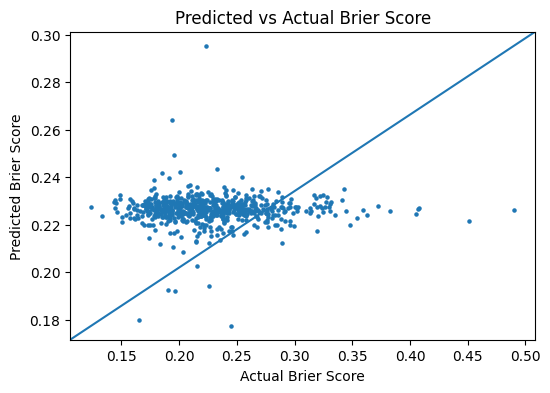

In [10]:
# Plot predictions against actual values
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.scatter(y_test, y_pred, s=5)
ax.set_xlabel("Actual Brier Score")
ax.set_ylabel("Predicted Brier Score")
ax.set_title("Predicted vs Actual Brier Score")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.show()